# Laptop Pricing Project

### Importing Required Libraries 

In [1]:
import piplite
await piplite.install('seaborn')

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from tqdm import tqdm
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
%matplotlib inline

### Import the Dataset

In [3]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

In [4]:
file_path= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod1.csv"

In [5]:
await download(file_path, "laptops.csv")
file_name="laptops.csv"

In [6]:
df = pd.read_csv(file_name, header=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      238 non-null    int64  
 1   Manufacturer    238 non-null    object 
 2   Category        238 non-null    int64  
 3   Screen          238 non-null    object 
 4   GPU             238 non-null    int64  
 5   OS              238 non-null    int64  
 6   CPU_core        238 non-null    int64  
 7   Screen_Size_cm  234 non-null    float64
 8   CPU_frequency   238 non-null    float64
 9   RAM_GB          238 non-null    int64  
 10  Storage_GB_SSD  238 non-null    int64  
 11  Weight_kg       233 non-null    float64
 12  Price           238 non-null    int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 22.4+ KB


In [8]:
df.head()

,Unnamed: 0,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_cm,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price
0,0,Acer,4,IPS Panel,2,1,5,35.560,1.6,8,256,1.60,978
1,1,Dell,3,Full HD,1,1,3,39.624,2.0,4,256,2.20,634
2,2,Dell,3,Full HD,1,1,7,39.624,2.7,8,256,2.20,946
3,3,Dell,4,IPS Panel,2,1,5,33.782,1.6,8,128,1.22,1244
4,4,HP,4,Full HD,2,1,7,39.624,1.8,8,256,1.91,837


Update the `Screen_Size_cm` column such that all values are rounded to nearest 2 decimal places by using `numpy.round()`

In [9]:
df[['Screen_Size_cm']] = np.round(df[['Screen_Size_cm']],2)
df.head()

,Unnamed: 0,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_cm,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price
0,0,Acer,4,IPS Panel,2,1,5,35.56,1.6,8,256,1.60,978
1,1,Dell,3,Full HD,1,1,3,39.62,2.0,4,256,2.20,634
2,2,Dell,3,Full HD,1,1,7,39.62,2.7,8,256,2.20,946
3,3,Dell,4,IPS Panel,2,1,5,33.78,1.6,8,128,1.22,1244
4,4,HP,4,Full HD,2,1,7,39.62,1.8,8,256,1.91,837


### Dealing with Missing Data

In [10]:
#Evaluate the dataset for missing data
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Unnamed: 0
False    238
Name: Unnamed: 0, dtype: int64

Manufacturer
False    238
Name: Manufacturer, dtype: int64

Category
False    238
Name: Category, dtype: int64

Screen
False    238
Name: Screen, dtype: int64

GPU
False    238
Name: GPU, dtype: int64

OS
False    238
Name: OS, dtype: int64

CPU_core
False    238
Name: CPU_core, dtype: int64

Screen_Size_cm
False    234
True       4
Name: Screen_Size_cm, dtype: int64

CPU_frequency
False    238
Name: CPU_frequency, dtype: int64

RAM_GB
False    238
Name: RAM_GB, dtype: int64

Storage_GB_SSD
False    238
Name: Storage_GB_SSD, dtype: int64

Weight_kg
False    233
True       5
Name: Weight_kg, dtype: int64

Price
False    238
Name: Price, dtype: int64



#### Replace with mean

Missing values in attributes that have continuous data are best replaced using Mean value. We note that values in "Weight_kg" attribute are continuous in nature, and some values are missing,

In [11]:
# replace missing data with mean
avg_weight = df['Weight_kg'].astype('float').mean(axis=0) # astype() function converts the values to the desired data type
df['Weight_kg'].replace(np.nan, avg_weight, inplace=True) # axis=0 indicates that the mean value is to calculated across all column elements in a row.

#### Replace with the most frequent value

Missing values in attributes that have categorical data are best replaced using the most frequent value. We note that values in "Screen_Size_cm" attribute are categorical in nature, and some values are missing. Therefore, we will replace this column's missing data with the most frequent value.

In [12]:
common_screen_size = df['Screen_Size_cm'].value_counts().idxmax()
df['Screen_Size_cm'].replace(np.nan, common_screen_size, inplace=True)

### Fixing the Data Types

Both "Weight_kg" and "Screen_Size_cm" are seen to have the data type "Object", we will convert them to 'float' data type.

In [13]:
df[['Weight_kg','Screen_Size_cm']] = df[['Weight_kg','Screen_Size_cm']].astype('float')

### Data Standardization
The value of Screen_size usually has a standard unit of inches. Similarly, weight of the laptop is needed to be in pounds. So, we will convert the weihgt from kg to pound and the size from cm to inches.

In [14]:
# Data standardization: convert weight from kg to pounds
df["Weight_kg"] = df["Weight_kg"]*2.205
df.rename(columns={'Weight_kg':'Weight_pounds'}, inplace=True)

# Data standardization: convert screen size from cm to inch
df["Screen_Size_cm"] = df["Screen_Size_cm"]/2.54
df.rename(columns={'Screen_Size_cm':'Screen_Size_inch'}, inplace=True)

### Data Normalization
Often it is required to normalize a continuous data attribute. So, we need to normalize the "CPU_frequency" attribute with respect to the maximum value available in the dataset.

In [15]:
df['CPU_frequency'] = df['CPU_frequency']/df['CPU_frequency'].max()

### Binning
Binning is a process of generating a categorical attribute which splits the values of a continuous data into a specified number of groups. We will generate 3 bins for the attribute 'Price' and name the bins as 'Low', 'Medium' and 'High'. Then rename the column name as 'Price-binned'.

In [16]:
bins = np.linspace(min(df["Price"]), max(df["Price"]), 4)
group_names = ['Low', 'Medium', 'High']
df['Price-binned'] = pd.cut(df['Price'], bins, labels=group_names, include_lowest=True )

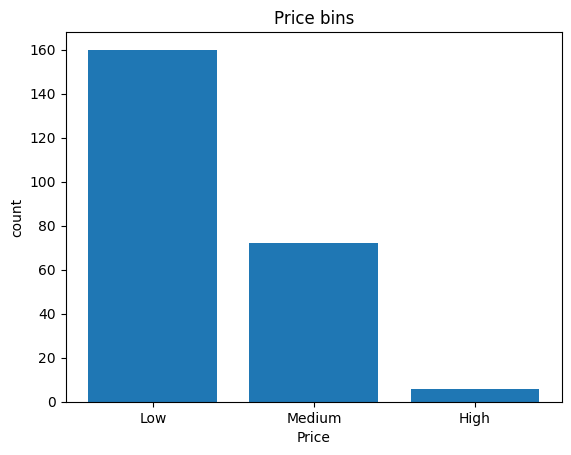

In [17]:
#plot the bar graph of these bins
plt.bar(group_names, df["Price-binned"].value_counts())
plt.xlabel("Price")
plt.ylabel("count")
plt.title("Price bins");

### Indicator Variables

 We will convert the "Screen" attribute of the dataset into 2 indicator variables, "Screen-IPS_panel" and "Screen-Full_HD".So, we do not need the 'Screen' column anymore. Therefore, we will drop this column.

In [18]:
#Indicator Variable: Screen
dummy_variable_1 = pd.get_dummies(df["Screen"])
dummy_variable_1.rename(columns={'IPS Panel':'Screen-IPS_panel', 'Full HD':'Screen-Full_HD'}, inplace=True)
df = pd.concat([df, dummy_variable_1], axis=1)

# drop original column "Screen" from "df"
df.drop("Screen", axis = 1, inplace=True)


In [19]:
df.head()

,Unnamed: 0,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,Price-binned,Screen-Full_HD,Screen-IPS_panel
0,0,Acer,4,2,1,5,14.000000,0.551724,8,256,3.52800,978,Low,0,1
1,1,Dell,3,1,1,3,15.598425,0.689655,4,256,4.85100,634,Low,1,0
2,2,Dell,3,1,1,7,15.598425,0.931034,8,256,4.85100,946,Low,1,0
3,3,Dell,4,2,1,5,13.299213,0.551724,8,128,2.69010,1244,Low,0,1
4,4,HP,4,2,1,7,15.598425,0.620690,8,256,4.21155,837,Low,1,0


# Visualize individual feature patterns

## Continuous Valued Feature
In this section, we will generate regression plots for each of the parameters "CPU_frequency", "Screen_Size_inch" and "Weight_pounds" against "Price". Also, we will print the value of correlation of each feature with "Price".

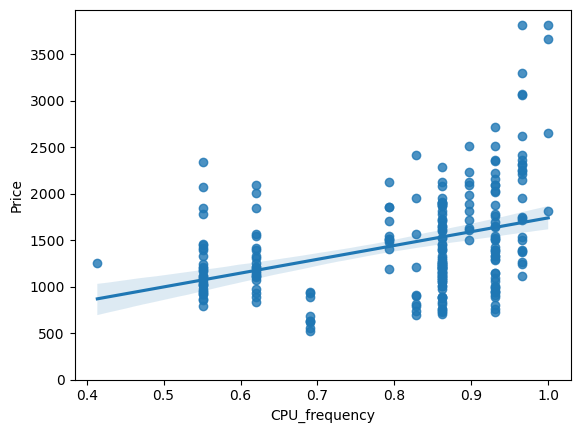

In [20]:
sns.regplot(x='CPU_frequency', y='Price', data=df)
plt.ylim(0,);

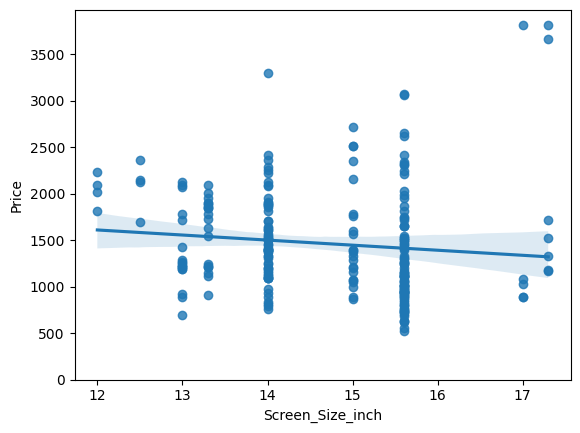

In [21]:
sns.regplot(x='Screen_Size_inch', y='Price', data=df)
plt.ylim(0,);

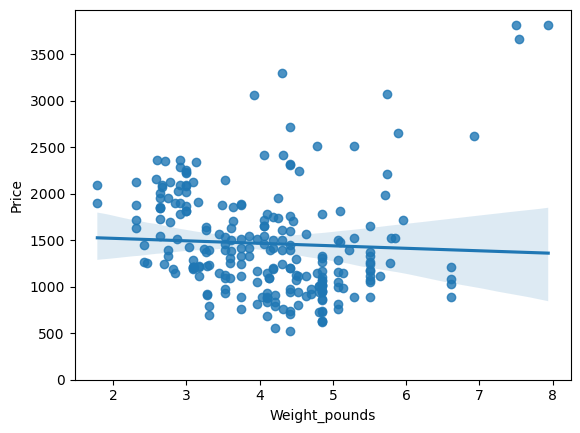

In [22]:
sns.regplot(x='Weight_pounds', y='Price', data=df)
plt.ylim(0,);

In [23]:
for param in ["CPU_frequency", "Screen_Size_inch","Weight_pounds"]:
    print(f"Correlation of Price and {param} is ", df[[param,"Price"]].corr())

Correlation of Price and CPU_frequency is                 CPU_frequency     Price
CPU_frequency       1.000000  0.366666
Price               0.366666  1.000000
Correlation of Price and Screen_Size_inch is                    Screen_Size_inch     Price
Screen_Size_inch          1.000000 -0.110565
Price                    -0.110565  1.000000
Correlation of Price and Weight_pounds is                 Weight_pounds     Price
Weight_pounds       1.000000 -0.050312
Price              -0.050312  1.000000


"CPU_frequency" has a 36% positive correlation with the price of the laptops. The other two parameters have weak correlation with price.

## Categorical Features
Here, we will generate box plots for the different feature that hold categorical values. These features would be "Category", "GPU", "OS", "CPU_core", "RAM_GB", "Storage_GB_SSD"

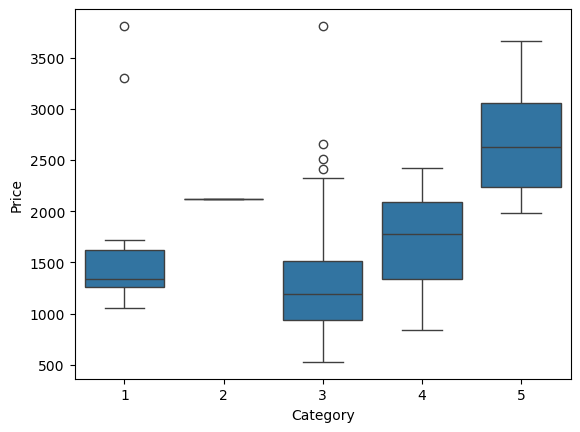

In [24]:
#Boxplot for 'Category' and 'Price'
sns.boxplot(x='Category', y='Price', data=df);

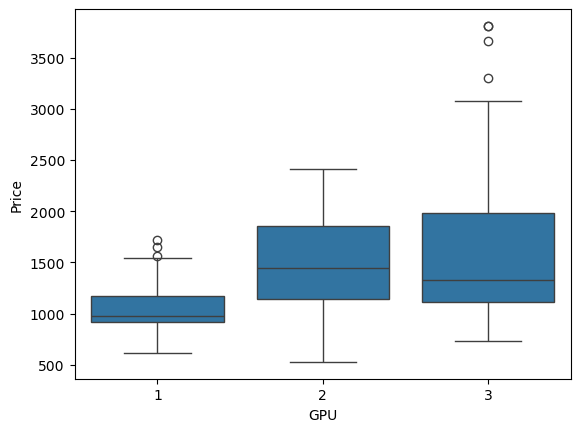

In [25]:
#Boxplot for 'GPU' and 'Price'
sns.boxplot(x='GPU', y='Price', data=df);

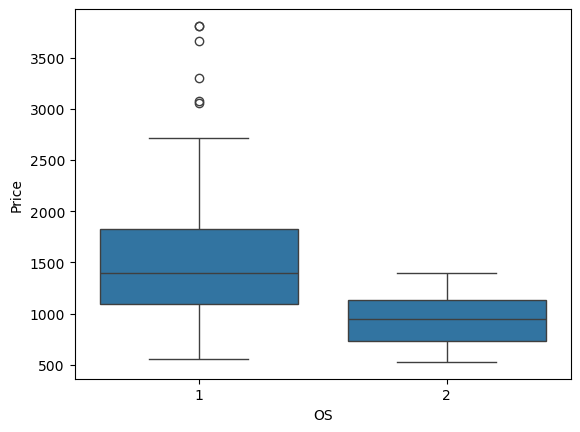

In [26]:
#Boxplot for 'OS' and 'Price'
sns.boxplot(x='OS', y='Price', data=df);

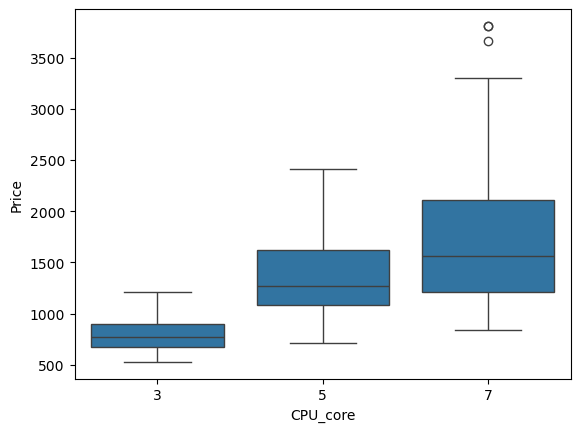

In [27]:
#Boxplot for 'CPU_core' and 'Price'
sns.boxplot(x='CPU_core', y='Price', data=df);

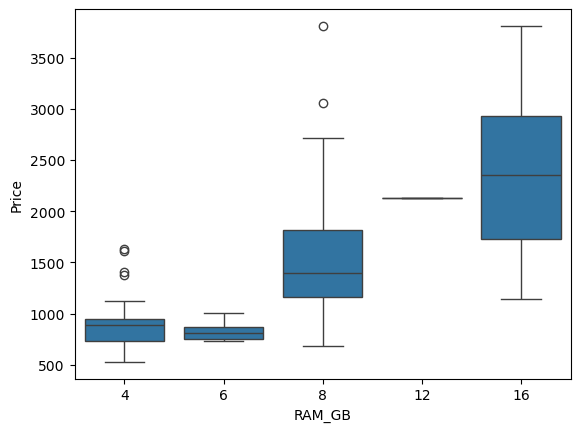

In [28]:
#Boxplot for RAM_GB and Price
sns.boxplot(x='RAM_GB', y='Price', data=df);

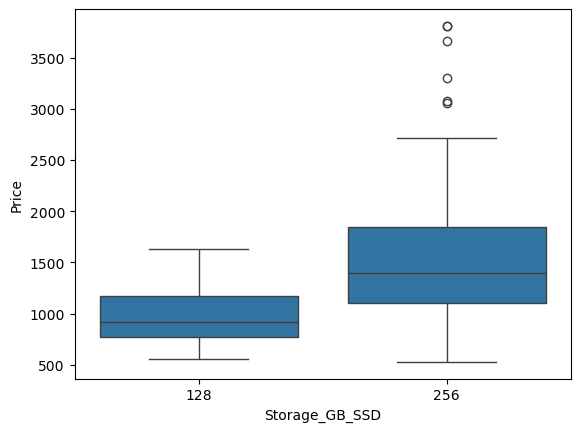

In [29]:
#Boxplot 'Storage_GB_SSD' and 'Price'
sns.boxplot(x='Storage_GB_SSD', y='Price', data=df);


## Descriptive Statistical Analysis

In [30]:
print(df.describe())
print(df.describe(include=['object']))

       Unnamed: 0    Category         GPU          OS    CPU_core  \
count  238.000000  238.000000  238.000000  238.000000  238.000000   
mean   118.500000    3.205882    2.151261    1.058824    5.630252   
std     68.848868    0.776533    0.638282    0.235790    1.241787   
min      0.000000    1.000000    1.000000    1.000000    3.000000   
25%     59.250000    3.000000    2.000000    1.000000    5.000000   
50%    118.500000    3.000000    2.000000    1.000000    5.000000   
75%    177.750000    4.000000    3.000000    1.000000    7.000000   
max    237.000000    5.000000    3.000000    2.000000    7.000000   

       Screen_Size_inch  CPU_frequency      RAM_GB  Storage_GB_SSD  \
count        238.000000     238.000000  238.000000      238.000000   
mean          14.687951       0.813822    7.882353      245.781513   
std            1.165589       0.141860    2.482603       34.765316   
min           12.000000       0.413793    4.000000      128.000000   
25%           14.000000     

## GroupBy and Pivot Tables
Group the parameters "GPU", "CPU_core" and "Price" to make a pivot table and visualize this connection using the pcolor plot.

In [31]:
df_gptest = df[['GPU','CPU_core','Price']]
grouped_test1 = df_gptest.groupby(['GPU','CPU_core'],as_index=False).mean()
print(grouped_test1)

   GPU  CPU_core        Price
0    1         3   769.250000
1    1         5   998.500000
2    1         7  1167.941176
3    2         3   785.076923
4    2         5  1462.197674
5    2         7  1744.621622
6    3         3   784.000000
7    3         5  1220.680000
8    3         7  1945.097561


In [32]:
grouped_pivot = grouped_test1.pivot(index='GPU',columns='CPU_core')
print(grouped_pivot)

               Price                          
CPU_core           3            5            7
GPU                                           
1         769.250000   998.500000  1167.941176
2         785.076923  1462.197674  1744.621622
3         784.000000  1220.680000  1945.097561


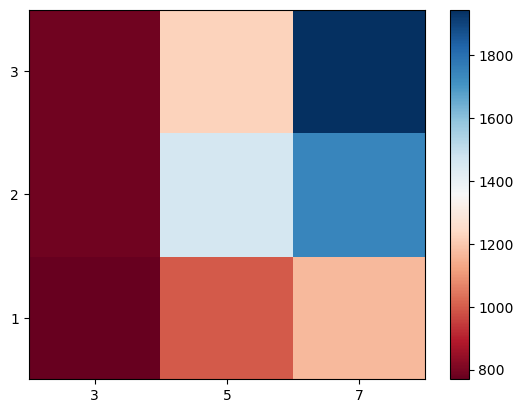

In [33]:
fig, ax = plt.subplots()
im = ax.pcolor(grouped_pivot, cmap='RdBu')

#label names
row_labels = grouped_pivot.columns.levels[1]
col_labels = grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

fig.colorbar(im);

## Pearson Correlation and p-values
We will use the `scipy.stats.pearsonr()` function to evaluate the Pearson Coefficient and the p-values for each parameter tested above. This will help us determine the parameters most likely to have a strong effect on the price of the laptops.

In [36]:
for param in ['RAM_GB','CPU_frequency','Storage_GB_SSD','Screen_Size_inch','Weight_pounds','CPU_core','OS','GPU','Category']:
    pearson_coef, p_value = stats.pearsonr(df[param], df['Price'])
    print(param)
    print("The Pearson Correlation Coefficient for ",param," is", pearson_coef, " with a P-value of P =", p_value)

RAM_GB
The Pearson Correlation Coefficient for  RAM_GB  is 0.5492972971857849  with a P-value of P = 3.6815606288424503e-20
CPU_frequency
The Pearson Correlation Coefficient for  CPU_frequency  is 0.366665558925886  with a P-value of P = 5.50246335071342e-09
Storage_GB_SSD
The Pearson Correlation Coefficient for  Storage_GB_SSD  is 0.24342075521810297  with a P-value of P = 0.00014898923191724168
Screen_Size_inch
The Pearson Correlation Coefficient for  Screen_Size_inch  is -0.1105647127542506  with a P-value of P = 0.08876456732700734
Weight_pounds
The Pearson Correlation Coefficient for  Weight_pounds  is -0.050312258377515455  with a P-value of P = 0.4397693853433897
CPU_core
The Pearson Correlation Coefficient for  CPU_core  is 0.45939777733551174  with a P-value of P = 7.912950127008979e-14
OS
The Pearson Correlation Coefficient for  OS  is -0.22172980114827356  with a P-value of P = 0.0005696642559246805
GPU
The Pearson Correlation Coefficient for  GPU  is 0.2882981988881427  wit

## Single Linear Regression
We will generate a single feature Linear Regression model that fits the pair of "CPU_frequency" and "Price" to find the model for prediction.

In [37]:
lm = LinearRegression()
X = df[['CPU_frequency']]
Y = df['Price']

lm.fit(X,Y)
Yhat = lm.predict(X)

Generate the Distribution plot for the predicted values and that of the actual values.

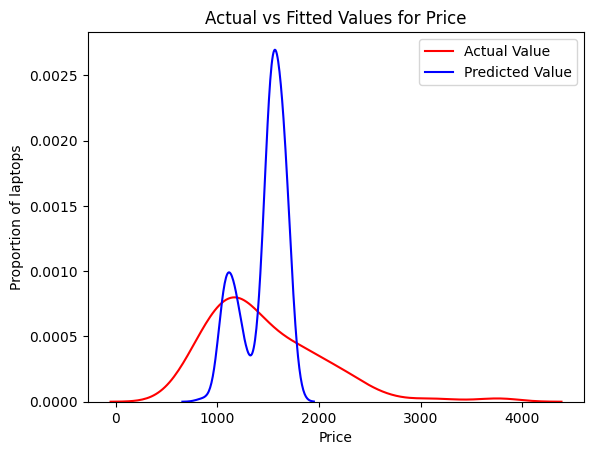

In [38]:
ax1 = sns.distplot(df['Price'], hist=False, color="r", label="Actual Value")

# Generate a distribution plot for predicted values
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion of laptops')
plt.legend(['Actual Value', 'Predicted Value'])
plt.show()

Evaluate the Mean Squared Error and R^2 score values for the model.

In [39]:
mse_slr = mean_squared_error(df['Price'], Yhat)
r2_score_slr = lm.score(X, Y)
print('The R-square for Linear Regression is: ', r2_score_slr)
print('The mean square error of price and predicted value is: ', mse_slr)

The R-square for Linear Regression is:  0.1344436321024326
The mean square error of price and predicted value is:  284583.4405868629


## Multiple Linear Regression
The parameters which have a low enough p-value so as to indicate strong relationship with the 'Price' value are 'CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU' and 'Category'. Use all these variables to write a Multiple Linear Regression system.

In [40]:
lm1 = LinearRegression()
Z = df[['CPU_frequency','RAM_GB','Storage_GB_SSD','CPU_core','OS','GPU','Category']]
lm1.fit(Z,Y)
Y_hat = lm1.predict(Z)

Plot the Distribution graph of the predicted values as well as the Actual values

Text(0, 0.5, 'Proportion of laptops')

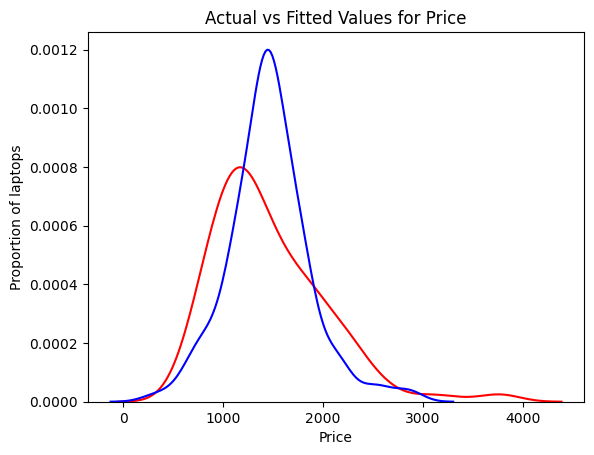

In [41]:
ax1 = sns.distplot(df['Price'], hist=False, color="r", label="Actual Value")
sns.distplot(Y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion of laptops')

Find the R^2 score and the MSE value for this fit

In [42]:
mse_slr1 = mean_squared_error(df['Price'], Y_hat)
r2_score_slr1 = lm1.score(Z, Y)
print('The R-square for Multiple Linear Regression is: ', r2_score_slr1)
print('The mean square error of price and predicted value is: ', mse_slr1)

The R-square for Multiple Linear Regression is:  0.5082509055187374
The mean square error of price and predicted value is:  161680.57263893107


As we see above from 2 models, The R-square of multiple linear regression is higher than Simple Linear Regression and the MSE of Multiple model is lower than Simple model. Therefore, we can say that multiple model is better than simple model.

## Polynomial Regression

We will use the variable "CPU_frequency" to find Polynomial features.

In [43]:
# 3 different values of Polynomial degrees
X = X.to_numpy().flatten()
f1 = np.polyfit(X, Y, 1)
p1 = np.poly1d(f1)

f3 = np.polyfit(X, Y, 3)
p3 = np.poly1d(f3)

f5 = np.polyfit(X, Y, 5)
p5 = np.poly1d(f5)

Plot the regression output against the actual data points to note how the data fits in each case.

In [44]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(independent_variable.min(),independent_variable.max(),100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title(f'Polynomial Fit for Price ~ {Name}')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Price of laptops')

Call this function for the 3 models generated and get the required graphs.

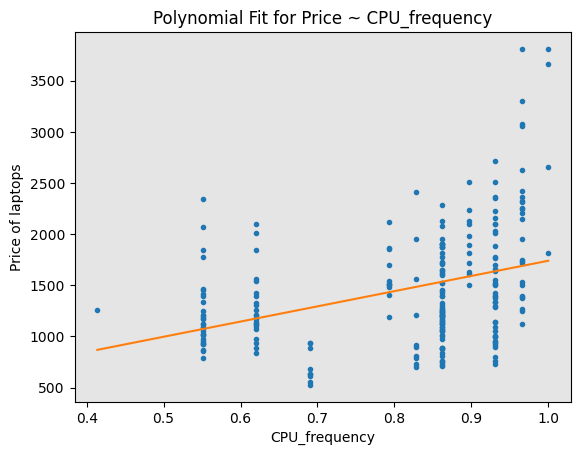

In [45]:
PlotPolly(p1, X, Y, 'CPU_frequency')

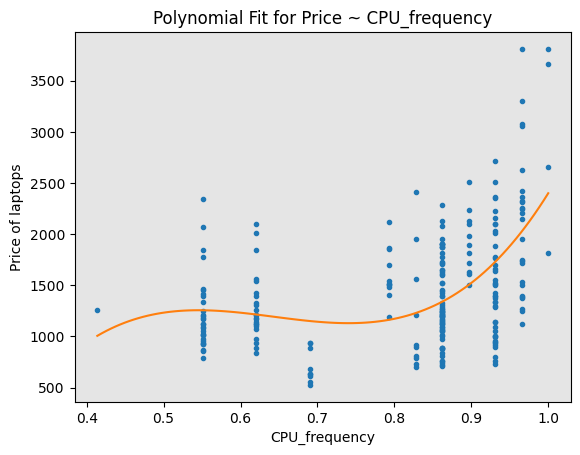

In [46]:
PlotPolly(p3, X, Y, 'CPU_frequency')

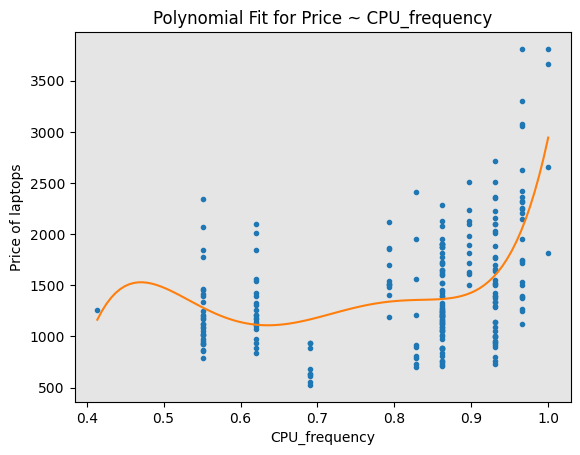

In [47]:
PlotPolly(p5, X, Y, 'CPU_frequency')

Also, calculate the R^2 and MSE values for these fits. For polynomial functions, the function sklearn.metrics.r2_score will be used to calculate R^2 values.

In [48]:
r_squared_1 = r2_score(Y, p1(X))
print('The R-square value for 1st degree polynomial is: ', r_squared_1)
print('The MSE value for 1st degree polynomial is: ', mean_squared_error(Y,p1(X)))
r_squared_3 = r2_score(Y, p3(X))
print('The R-square value for 3rd degree polynomial is: ', r_squared_3)
print('The MSE value for 3rd degree polynomial is: ', mean_squared_error(Y,p3(X)))
r_squared_5 = r2_score(Y, p5(X))
print('The R-square value for 5th degree polynomial is: ', r_squared_5)
print('The MSE value for 5th degree polynomial is: ', mean_squared_error(Y,p5(X)))

The R-square value for 1st degree polynomial is:  0.1344436321024326
The MSE value for 1st degree polynomial is:  284583.4405868629
The R-square value for 3rd degree polynomial is:  0.26692640796531153
The MSE value for 3rd degree polynomial is:  241024.86303848756
The R-square value for 5th degree polynomial is:  0.3030822706443219
The MSE value for 5th degree polynomial is:  229137.29548055748


## Pipeline
Generate a pipeline that performs parameter scaling, Polynomial Feature generation and Linear regression.

In [49]:
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model',LinearRegression())]
pipe=Pipeline(Input)
Z = Z.astype(float)
pipe.fit(Z,Y)
ypipe=pipe.predict(Z)

Evaluate the MSE and R^2 values for the this predicted output.

In [50]:
print('MSE for multi-variable polynomial pipeline is: ', mean_squared_error(Y, ypipe))
print('R^2 for multi-variable polynomial pipeline is: ', r2_score(Y, ypipe))

MSE for multi-variable polynomial pipeline is:  576258.0336134454
R^2 for multi-variable polynomial pipeline is:  -0.7526803721174535


## Using Cross Validation to Improve the Model
In this section, divide the dataset into x_data and y_data where y_data is the 'price' attribute and x_data has all other attributes.

In [52]:
y_data = df['Price']
x_data = df.drop('Price', axis=1)

Split the data set into training and testing subests such that you reserve 10% of the data set for testing purposes.

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 24
number of training samples: 214


Write a single variable linear regression model using "CPU_frequency" parameter. Print the R^2 value of this model for the training and testing subsets.

In [56]:
lre = LinearRegression()
lre.fit(x_train[['CPU_frequency']], y_train)
print(lre.score(x_test[['CPU_frequency']],y_test))
print(lre.score(x_train[['CPU_frequency']], y_train))

-0.06599437350393766
0.14829792099817973


Run a 4-fold cross validation on the model and print the mean value of R^2 score along with its standard deviation.

In [57]:
Rcross = cross_val_score(lre, x_data[['CPU_frequency']], y_data, cv=4)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are -0.16109232388595224 and the standard deviation is 0.3849579786664727


## Overfitting
Split the data set into training and testing components again, this time reserving 50% of the data set for testing.

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=0)

o identify the point of overfitting the model on the parameter "CPU_frequency", you'll need to generate polynomial features using the single attribute. You need to evaluate the R^2 scores of the model generated using different degrees of polynomial features, ranging from 1 to 5. Save this set of values of R^2 score as a list.

In [59]:
lre = LinearRegression()
Rsqu_test = []
order = [1, 2, 3, 4, 5]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train[['CPU_frequency']])
    x_test_pr = pr.fit_transform(x_test[['CPU_frequency']])    
    lre.fit(x_train_pr, y_train)
    Rsqu_test.append(lre.score(x_test_pr, y_test))

Plot the values of R^2 scores against the order

Text(0.5, 1.0, 'R^2 Using Test Data')

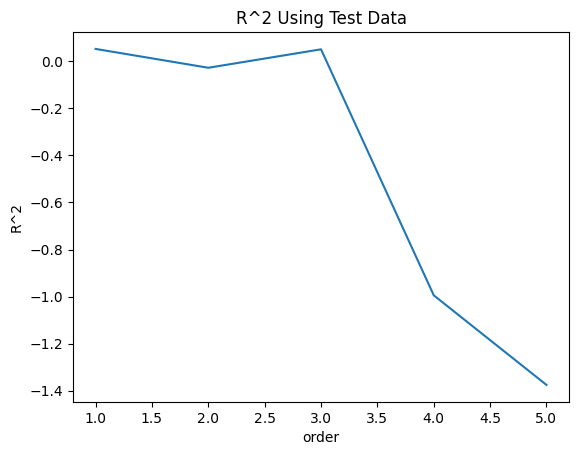

In [60]:
plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')

## Ridge Regression 
Write a polynomial model that uses 'CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU' and 'Category' parameters with degree=2. Also, divide the training and testing attributes.  

In [61]:
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])
x_test_pr=pr.fit_transform(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])

Generate a Ridge Regression model and evaluate it using values of the hyperparameter alpha ranging from 0.001 to 1 with increments of 0.001. Generate a list of all Ridge Regression R^2 scores for training and testing data.

In [62]:
Rsqu_test = []
Rsqu_train = []
Alpha = np.arange(0.001,1,0.001)
pbar = tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha) 
    RigeModel.fit(x_train_pr, y_train)
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})
    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

<ipython-input-62-d489d0218bed>:4: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  pbar = tqdm(Alpha)
100%|██████████| 999/999 [00:02<00:00, 415.21it/s, Test Score=0.423, Train Score=0.669]


Plot the R^2 values for training and testing sets with respect to the value of alpha

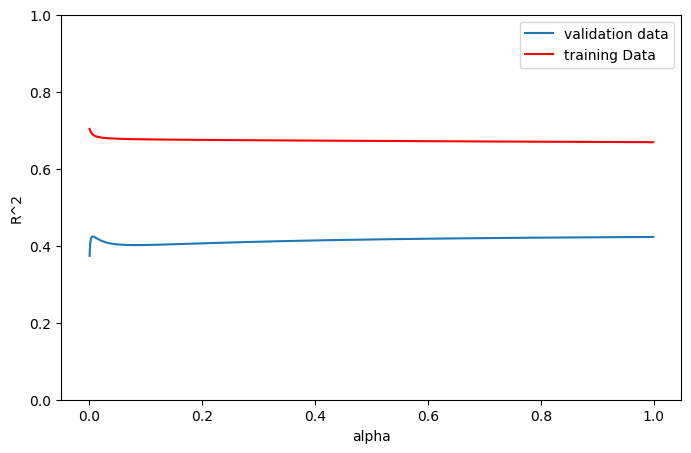

In [66]:
plt.figure(figsize=(8, 5))  
plt.plot(Alpha, Rsqu_test, label='validation data')
plt.plot(Alpha, Rsqu_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0, 1)
plt.legend();

## Grid Search
Using the raw data and the same set of features as used above, use GridSearchCV to identify the value of alpha for which the model performs best. 
Assume the set of alpha values to be used as
```math
{0.0001, 0.001, 0.01, 0.1, 1, 10}
```

In [67]:
parameters1= [{'alpha': [0.0001,0.001,0.01, 0.1, 1, 10]}]

Write a Ridge instance and run Grid Search using a 4 fold cross validation.

In [68]:
RR=Ridge()
Grid1 = GridSearchCV(RR, parameters1,cv=4)

Fit the Grid Search to the training data.

In [69]:
Grid1.fit(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']], y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}])

Print the R^2 score for the test data using the estimator that uses the derived optimum value of alpha.

In [70]:
BestRR=Grid1.best_estimator_
print(BestRR.score(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU','Category']], y_test))

0.3009905048691819
